In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
import matplotlib.patches as patches
import matplotlib.path as path

import scipy.linalg as la
import numpy.random as rnd

# shapely and descartes must be installed separately.
from shapely.geometry import Point, Polygon, LineString
import shapely.ops as ops
import descartes

# This is Andy's hand-cooked kernel module. 
# Probably better to replace with something like GPy.
import kernels as kn
reload(kn)
%matplotlib inline

In [2]:
# These are some helper functions
def inequalityMatrices(verts):
    """
    Convert a polygon stored as a collection of vertices (assuming listed in order)
    to a constraint of the form
    Ax <= B
    """
    
    n = len(verts)
    
    A = np.zeros((n,2))
    b = np.zeros(n)
    
    for k in range(n):
        M = np.hstack((np.zeros((2,2)),np.ones((2,1))))
        M[0,:2] = verts[k]
        M[1,:2] = verts[(k+1) % n]
        U,S,Vh = la.svd(M)
        V2 = Vh[-1]
        vec = np.hstack((verts[(k+2) % n],1))
        sgn = 1. if np.dot(V2,vec) < 0 else -1.
        A[k,:] = sgn * V2[:2]
        b[k] = -sgn * V2[-1]
        
    return A,b
    
    

def isCollision(g,constraintList):
    x = g[:2]
    for  A,b in constraintList:
        res = b - np.dot(A,x)
        if res.min() >= 0:
            return True
    return False

def rangeFinderValue(g,constraintList):
    """
    Given g = (x,y,theta), this finds the point on the nearest polygon that the laser range-finder would hit.
    
    """
    x = g[:2]
    theta = g[-1]
    TList = np.zeros(len(constraintList))
    for k in range(len(constraintList)):
        A,b = constraintList[k]
        a = np.dot(A,np.array([np.cos(theta),np.sin(theta)]))
        bCur = b - np.dot(A,x)
        NegInd = a < 0
        PosInd = a >= 0
        
        # This will have issues if the beam is exactly parallel to an edge
        
        tLow = np.max(bCur[NegInd]/a[NegInd])
        tHigh = np.min(bCur[PosInd]/a[PosInd])
        
        t = tLow if (tLow <= tHigh) and (tLow >=0) else np.inf
        
        TList[k] = t
        
        d = TList.min()
        
    return d


def carPolygon(g):
    cL = 2.
    cW = 1.
    
    x = g[:2]
    theta = g[-1]
    
    R = np.array([[np.cos(theta),-np.sin(theta)],
                  [np.sin(theta),np.cos(theta)]])
    
    carPoly = np.array([[-cL/2,-cW/2],
                        [cL/2,0],
                        [-cL/2,cW/2]])
    
    carPoly = np.dot(carPoly,R.T) + np.outer(np.ones(3),x)
    
    return Polygon(carPoly)


def sort_zeros(arr):
    pos=0           
    for i in range(len(arr)):
        if arr[i] != 0:
            arr[pos] = arr[i]
            pos += 1

    for i in reversed(range(pos, len(arr))):
        arr[i] = 0
        
    return arr

def EKF_propagate(x_hat_plus,P_plus,w_m,v_m,dt):
    diagonal=np.matrix([[0.01*0.01, 0],
                       [0, 0.01*0.04]]).reshape(2,2)
    x_hat_min = np.empty([len(x_hat_plus)]).reshape((len(x_hat_plus), 1))
    x_hat_min[0:3]=x_hat_plus[0:3]+dt*np.array([[v_m*np.cos(x_hat_plus[2,0]),
                                                 v_m*np.sin(x_hat_plus[2,0]),
                                                                       w_m]]).reshape((3, 1))
    x_hat_min[3:]=x_hat_plus[3:]
    #Jacobian

    Phi = np.matrix([[1, 0, -dt*v_m*np.sin(x_hat_plus[2,0]),
                      0, 1,  dt*v_m*np.cos(x_hat_plus[2,0]),
                      0, 0, 1                                ]]).reshape((3, 3))
    G = -dt*np.matrix([[np.cos(x_hat_plus[2,0]), 0,
                       np.sin(x_hat_plus[2,0]), 0,
                                         0, 1]]).reshape((3, 2))
    P_min=np.zeros((len(P_plus),len(P_plus)))
    P_min[0:3,0:3]=Phi*P_plus[0:3,0:3]*Phi.transpose()+G*v_m**2*diagonal*G.transpose()
    P_min= (P_min+P_min.transpose())/2
    if len(P_plus) > 3:
        P_min[0:3,3:]=Phi*P_plus[0:3,3:]
        P_min[3:,0:3]=P_min[0:3,3:].transpose()
        P_min[3:,3:]=P_plus[3:,3:]
    
    P_min= (P_min+P_min.transpose())/2
    return  x_hat_min,P_min        

def EKF_update(x_hat_min,P_min,z_dist,z_theta,gamma_match,gamma_newlm,sigma_d,sigma_th):
    R=np.matrix([[sigma_d*sigma_d, 0],
                [0, sigma_th*sigma_th]]).reshape(2,2)
    n_z=len(z_dist)
    z_p=np.asmatrix(np.zeros((2,n_z)))
    Rpi=np.zeros((2,2,n_z))
    n_m=(len(x_hat_min)-3)/2

    res=[]
    diagS=[]
    pri_l=[]

    J=np.matrix([[0, -1],
                [1,  0]]).reshape(2,2)

    for x in range(1, n_z+1):
        z_p[:,x-1]=z_dist[x-1]*np.matrix([np.cos(z_theta[x-1]),np.sin(z_theta[x-1])]).transpose()
        G=np.matrix([[np.cos(z_theta[x-1]), -z_dist[x-1]*np.sin(z_theta[x-1])],
                     [np.sin(z_theta[x-1]),  z_dist[x-1]*np.cos(z_theta[x-1])]]).reshape(2,2)
        Rpi[:,:,x-1]=G*R*G.transpose()


    for i in range(1, n_z+1):
        C=np.matrix([[np.cos(x_hat_min.item(2)), -np.sin(x_hat_min.item(2)),
                      np.sin(x_hat_min.item(2)),  np.cos(x_hat_min.item(2))]]).reshape(2,2)
        rij=np.asmatrix(np.zeros((2,n_m)))
        Hj=np.zeros((2,len(x_hat_min),n_m))
        Sij_inv=np.zeros((2,2,n_m))
        mdij=np.zeros((n_m,1))
        for j in range(1, n_m+1):
            S=x_hat_min[2+2*j-1:2+2*j+1]-x_hat_min[0:2]
            z_hat_j=np.asarray(C.T*S)
            Hj[:,0:3,j-1] = (-C).T*np.hstack((np.eye(2),J*S))
            Hj[:,2+2*j-1:2+2*j+1,j-1]=C.T
            rij[:,j-1]=z_p[:,i-1]-z_hat_j
            Sij_inv[:,:,j-1]=la.inv(Hj[:,:,j-1]*P_min*Hj[:,:,j-1].T+Rpi[:,:,i-1])
            mdij[j-1]=rij[:,j-1].T*np.asmatrix(Sij_inv[:,:,j-1])*rij[:,j-1]
        
        if not mdij.any():
            minmd=np.zeros((0,1))
            minij=np.zeros((0,1))
        else:
            minmd=mdij.min()
            minij=mdij.argmin()
            
        if not minmd.any() or minmd> gamma_newlm:
            #print "New landmark"
            p_newlm = x_hat_min[0:2]+C*z_p[:,i-1].reshape(2,1)
            x_hat_min=np.vstack((x_hat_min,p_newlm))
            HR=-C.T*np.hstack((np.eye(2),J*(p_newlm-x_hat_min[0:2])))
            HLi=C.T
            P_LL=HLi.T*(HR*P_min[0:3,0:3]*HR.T+Rpi[:,:,i-1]*HLi)
            P_xL=-P_min[:,0:3]*HR.T*HLi
            top=np.hstack((P_min,P_xL))
            bottom=np.hstack((P_xL.T,P_LL))
            P_min=np.vstack((top,bottom))
            
        elif minmd < gamma_match:
            K=P_min*Hj[:,:,minij].T*Sij_inv[:,:,minij]
            x_hat_min+K*rij[:,minij].reshape(2,1)
            P_min=(np.eye(len(P_min))-K*Hj[:,:,minij])*P_min*(np.eye(len(P_min))-K*Hj[:,:,minij]).T+K*Rpi[:,:,i-1]*K.T
            res=np.append(res,rij[:,minij].reshape(2,1))
            diagS=np.append(diagS,np.diagonal(la.inv(Sij_inv[:,:,minij])).reshape(2,1))
            
        x_hat_plus=x_hat_min
        P_plus=(P_min+P_min.T)/2
    return x_hat_plus,P_plus,res,diagS,minmd,mdij,minij

In [3]:
# Assume that vertices are enumerated counter-clockwise
# Build the constraints
#leftPoly = [[-20,-20],[-19,-20],[-19,20],[-20,20]]
#botPoly = [[-19,-20],[19,-20],[19,-19],[-19,-19]]
#rightPoly = [[19,-20],[20,-20],[20,20],[19,20]]
#topPoly = [[-19,19],[19,19],[19,20],[-19,20]]
#This part of code gives us the boundaries

leftPoly = [[-14,-14],[-13,-14],[-13,14],[-14,14]]
botPoly = [[-13,-14],[13,-14],[13,-13],[-13,-13]]
rightPoly = [[13,-14],[14,-14],[14,14],[13,14]]
topPoly = [[-13,13],[13,13],[13,14],[-13,14]]


#leftPoly = [[-8,-8],[-7,-8],[-7,8],[-8,8]]
#botPoly = [[-7,-8],[7,-8],[7,-7],[-7,-7]]
#rightPoly = [[7,-8],[8,-8],[8,8],[7,8]]
#topPoly = [[-7,7],[7,7],[7,8],[-7,8]]


# Number of obstacles
NumObs = 8


obsPoly = []

for obs in range(NumObs):
                 
    NumVert = rnd.randint(3,8)#Number of Vertices
                 
    Cen = 14. * rnd.rand(2) - 7.#Center of Polygon, eg - array([-6.50255021, -1.95047639])
    
    Theta = np.sort(2*np.pi * rnd.rand(NumVert))#Creates N Corner Angles, and np sorts them in ascending orderd  = rnd.rand(NumVert)#d is length of sides(assumption) 
    
    obsVert = np.outer(np.ones(NumVert),Cen) +  np.vstack((np.cos(Theta),np.sin(Theta))).T
    #adds center x co-ordinate with cos(theta) and y co-ordinate with sin(theta)
    
    obsPoly.append(obsVert)

shapeVerticesList = [leftPoly,botPoly,rightPoly,topPoly]

polyList = [Polygon(verts) for verts in shapeVerticesList]
#function Polygon creates polygons with vertices
#verts is the verts of each polygon

polyUnion = ops.unary_union(polyList)


#fig = plt.figure()
#fig.set_dpi(100)
#fig.set_size_inches(7, 7)

#ax = fig.add_subplot(111)
#ax = plt.axes(xlim=(-8, 8), ylim=(-8, 8))

#ax.add_patch(descartes.PolygonPatch(polyUnion,fc = 'blue',alpha=0.5))


obsList = [Polygon(verts) for verts in obsPoly]
obsUnion = ops.unary_union(obsList)

#for obs in obsList:
  #  ax.add_patch(descartes.PolygonPatch(obs,fc = 'blue',alpha=0.5))

constraintList = [inequalityMatrices(verts) for verts in shapeVerticesList]#+obsPoly]
#ax.axis('equal')

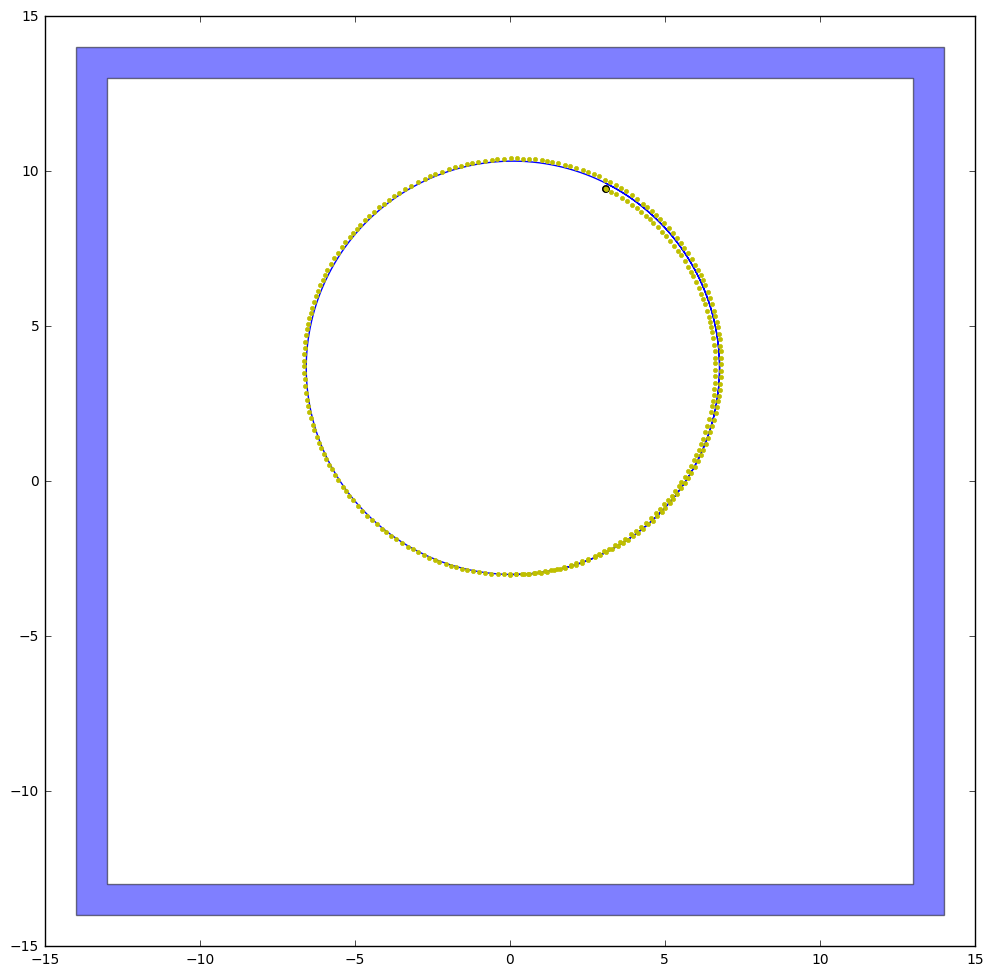

In [5]:
dt=1
N=300;
#true velocity. Changing this profile allows changing the trajectory
v_true=0.2*np.ones(N);

#true rotational velocity
w_true =0.03 *np.ones(N)
          
#Noise Strength
sigma_d = 0.1; # [m]    distance measurements
sigma_th= 0.04;# rad    bearing measurements

sigma_v = sigma_d*v_true;
sigma_w = sigma_th*w_true;

x_true=np.zeros(shape=(3,N))
x_true[:,0]=np.array([0,-3,0])


for pos in range(1,N):
    
    x_true[0,pos] = x_true[0,pos-1]+ v_true[pos-1]*dt*np.cos(x_true[2,pos-1]);#x
    x_true[1,pos]= x_true[1,pos-1]+ v_true[pos-1]*dt*np.sin(x_true[2,pos-1]);#y
    x_true[2,pos]= x_true[2,pos-1]+ w_true[pos-1]*dt;#phi

v_m=v_true+sigma_v*np.random.normal(0, 1, N)
w_m=w_true+sigma_w*np.random.normal(0, 1, N )    
    
x_m=np.zeros(shape=(3,N))
x_m[:,0]=np.array([0,-3,0])   
    

for pos in range(1,N):
    
    x_m[0,pos] = x_m[0,pos-1]+ v_m[pos-1]*dt*np.cos(x_true[2,pos-1]);#x
    x_m[1,pos]= x_m[1,pos-1]+ v_m[pos-1]*dt*np.sin(x_true[2,pos-1]);#y
    x_m[2,pos]= x_m[2,pos-1]+ w_m[pos-1]*dt;#phi    
  

x_s=x_true[0,:]
y_s=x_true[1,:]
ang=x_true[2,:]
rob = np.row_stack((x_s, y_s))
    
fig = plt.figure()
fig.set_dpi(100)
fig.set_size_inches(12, 12)
ax = fig.add_subplot(111)

ax.add_patch(descartes.PolygonPatch(polyUnion,fc = 'blue',alpha=0.5))
ax.plot(x_true[0,:],x_true[1,:])
#ax.plot(x_m[0,:],x_m[1,:])
patch = plt.Circle((5, -5), 0.1, fc='y')

def init():
    #patch.center = (5, 5)
    ax.add_patch(patch)
    return patch,

def animate(i):

    #carPoly = carPolygon(g)   
    patch.center = ([x_m[0,i],x_m[1,i]])
    #ax.plot([x[0],xInt[0]],[x[1],xInt[1]],'r')
    ax.plot(x_m[0,i],x_m[1,i],'y.')
    
    return patch,
    
anim = animation.FuncAnimation(fig, animate, 
                              init_func=init, 
                             frames=N, 
                              interval=600,
                              blit=True,repeat=True)
HTML(anim.to_html5_video())

In [8]:
x_m[0]

array([ 0.        ,  0.19699738,  0.37817236,  0.59560298,  0.80848274,
        1.00009874,  1.19815264,  1.41984666,  1.60524463,  1.78555821,
        1.96771373,  2.12546202,  2.32062953,  2.51885178,  2.74249468,
        2.91903155,  3.09670974,  3.30188879,  3.47877866,  3.65471306,
        3.80870626,  3.98889472,  4.1348749 ,  4.28619885,  4.45945333,
        4.60503193,  4.74803225,  4.89967735,  5.01616671,  5.15477082,
        5.27498523,  5.39067198,  5.53220177,  5.64886836,  5.75647255,
        5.8603548 ,  5.96393842,  6.06682624,  6.16313716,  6.2455384 ,
        6.32831088,  6.3964436 ,  6.46775809,  6.53291496,  6.5854625 ,
        6.6414351 ,  6.68695364,  6.72354967,  6.74909524,  6.77675114,
        6.796099  ,  6.81054704,  6.81912106,  6.82147847,  6.81762019,
        6.80661476,  6.79360743,  6.76909682,  6.74694811,  6.71012759,
        6.6717446 ,  6.6314941 ,  6.58404787,  6.51803112,  6.453603  ,
        6.38587208,  6.29905408,  6.22534092,  6.15364565,  6.07